In [1]:
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, classification_report, recall_score, f1_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate 
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from numpy import mean
pd.set_option('display.max_colwidth', -1)


In [2]:
df = pd.read_excel('1 выборка.xlsx')
df.shape

(2282, 24)

quite a high dim data

In [3]:
# prepare X and y

X = df.drop(['Наименование на английском','Банкрот', 'Регион', 'Кластер'],axis=1)
cols = X.columns

X = pd.DataFrame(X)
X.columns = cols

y = df['Банкрот']
y = pd.DataFrame(y)
y.columns = ['Банкрот']

In [4]:
Counter(y['Банкрот'])

Counter({0: 2253, 1: 29})

* 'bankrupt' class is coded as 1
* 'this is fine' class (not bankrupts) coded as 0

dataset is highly unbalanced (1:99) so I will use SMOTE algoritm with default settings, otherwise the models would just ignore minor class:
* split dataset into train (80%) and test (20%) sets
* generate new samples of minor class for training data to be balanced (whilte test set remains unchanged)

In [5]:
target_names = ['this is fine', 'bankrupt']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

### DECISION TREE

I would implement decision tree first to get some insights about whether there might be some more important features

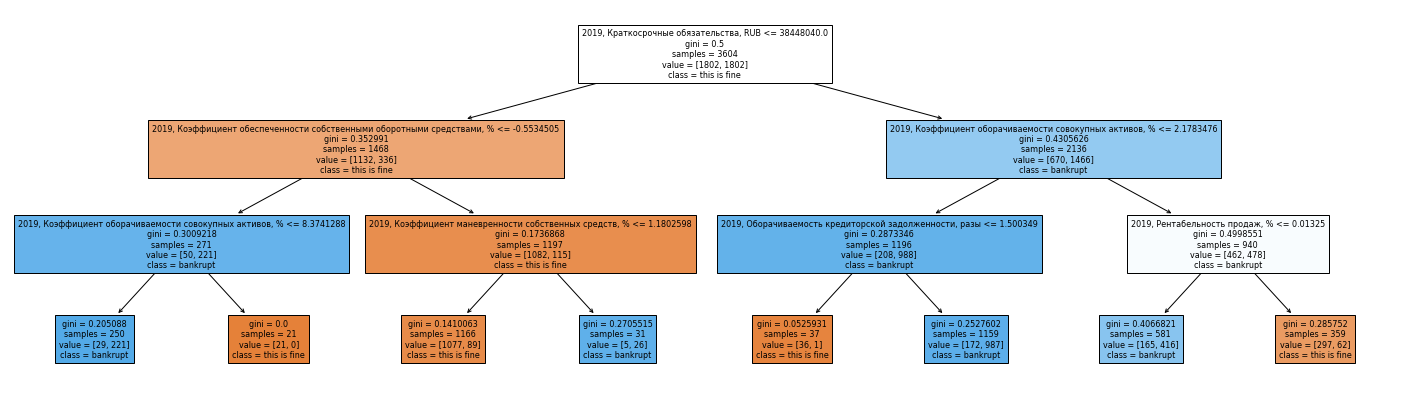

              precision    recall  f1-score   support

this is fine      0.994     0.785     0.877       451
    bankrupt      0.040     0.667     0.075         6

    accuracy                          0.783       457
   macro avg      0.517     0.726     0.476       457
weighted avg      0.982     0.783     0.867       457

[[354  97]
 [  2   4]]


In [7]:
clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=3)
clf.fit(X_train, y_train)

fig = plt.figure(figsize=(25, 7))
X.feature_names = X.columns

_ = tree.plot_tree(clf, filled=True, feature_names=X.feature_names, class_names=['this is fine', 'bankrupt'], fontsize=8, precision=7)
plt.show()
fig.savefig('tree.pdf')

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

Recall is very nice for both classes and what is more important: 4 out of 6 bankrupts are identified! The problem with decision tree here is that such a result is not stable. Cross validation was not implemented as I just wanted to get the most important features, this list is quite constant

I scale data since there are both absolute and rates values and rest of models is not able to handle unscaled data

In [8]:
scaler = MinMaxScaler()
scaler.fit(X)

X=scaler.transform(X)
X=pd.DataFrame(X)
X.columns = cols
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [9]:
def precision(conf):
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TP + FP) == 0:
        result = 0
    else:
        result = TP / (TP + FP)
    return round(result, 3)


def recall(conf):  # same as sensitivity
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TP + FN) == 0:
        result = 0
    else:    
        result = TP / (TP + FN)
    return round(result, 3)


def specificity(conf):
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TN + FP) == 0:
        result = 0
    else:    
        result = TN / (TN + FP)
    return round(result, 3)

### LOGISTIC REGRESSION

In [10]:
def sfs_compute(clf, X_train, y_train):
    for i in range(1,11):

        sfs = SequentialFeatureSelector(clf, n_features_to_select=i)
        sfs.fit(X_train, y_train)

        new_data = sfs.transform(X_train)

        clf.fit(new_data, y_train)

        new_test = sfs.transform(X_test)
        print('number of factors: ',i)
        print('accuracy: %.3f'% clf.score(new_test, y_test))
    
        y_pred = clf.predict(new_test)
        conf = confusion_matrix(y_test, y_pred)
    
    #print('accuracy: %.3f'% clf.score(new_test, y_test))
        print(conf)
        tn, fp, fn, tp = conf.ravel()
    
        accuracy_result = clf.score(new_test, y_test)
        accuracy_list.append(accuracy_result)
    
        tp_result = tp
        tp_list.append(tp_result)
        precision_result = precision(conf)
        precision_list.append(precision_result)
        recall_result = recall(conf)
        recall_list.append(recall_result)
        specificity_result = specificity(conf)
        specificity_list.append(specificity_result)
        print('')

In [11]:
accuracy_list = []
precision_list = []
specificity_list = []
recall_list = []
tp_list = []
clf = LogisticRegression(random_state=0)
    
sfs_compute(clf, X_train, y_train)

number of factors:  1
accuracy: 0.856
[[389  62]
 [  4   2]]

number of factors:  2
accuracy: 0.877
[[399  52]
 [  4   2]]

number of factors:  3
accuracy: 0.842
[[383  68]
 [  4   2]]

number of factors:  4
accuracy: 0.836
[[380  71]
 [  4   2]]

number of factors:  5
accuracy: 0.829
[[377  74]
 [  4   2]]

number of factors:  6
accuracy: 0.816
[[369  82]
 [  2   4]]

number of factors:  7
accuracy: 0.805
[[364  87]
 [  2   4]]

number of factors:  8
accuracy: 0.842
[[383  68]
 [  4   2]]

number of factors:  9
accuracy: 0.549
[[247 204]
 [  2   4]]

number of factors:  10
accuracy: 0.742
[[335 116]
 [  2   4]]



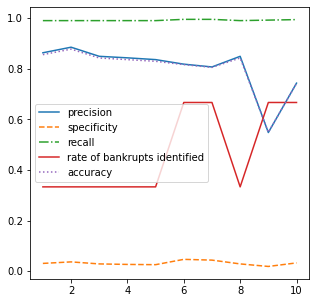

In [12]:
tp_plot = [x / 6 for x in tp_list]
number_of_leafs = list(range(1, 11))
# plot lines
font = {'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.figure(figsize=(5, 5))
plt.plot(number_of_leafs, precision_list, label="precision", linestyle="-")
plt.plot(number_of_leafs, specificity_list, label="specificity", linestyle="--")
plt.plot(number_of_leafs, recall_list, label="recall", linestyle="-.")
plt.plot(number_of_leafs, tp_plot, label="rate of bankrupts identified", linestyle="-")
plt.plot(number_of_leafs, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

as seen on plot 6 features (out of 20) is optimal number for logistic regression, so I would figure out what are these features names

In [18]:
clf = LogisticRegression(random_state=0) #.fit(X, y)

sfs = SequentialFeatureSelector(clf, n_features_to_select=6)
sfs.fit(X_train, y_train)
cols = sfs.get_support(indices=True)
X_important_features = X_train.iloc[:,cols]

check the features for high multi-collinearity using VIF

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_important_features.columns
X_important_features = X_important_features.assign(const=1)

pd.Series([variance_inflation_factor(X_important_features.values, i) 
               for i in range(X_important_features.shape[1])], 
              index=X_important_features.columns)

2019, Оборачиваемость кредиторской задолженности, разы                    3.452300   
2019, Коэффициент оборачиваемости совокупных активов, %                   3.447412   
2019, Коэффициент соотношения заемных и собственных средств, %            1.000037   
2019, Коэффициент обеспеченности собственными оборотными средствами, %    1.002621   
2019, Рентабельность затрат, %                                            1.000681   
2019, Коэффициент текущей ликвидности, %                                  1.006404   
const                                                                     3844.884946
dtype: float64

there are 2 features which are a bit highly correlated, so I drop 1 of it

In [20]:
X_important_features = X_important_features.drop('2019, Оборачиваемость кредиторской задолженности, разы', axis=1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_important_features.columns
X_important_features = X_important_features.assign(const=1)

pd.Series([variance_inflation_factor(X_important_features.values, i) 
               for i in range(X_important_features.shape[1])], 
              index=X_important_features.columns)

2019, Коэффициент оборачиваемости совокупных активов, %                   1.000478   
2019, Коэффициент соотношения заемных и собственных средств, %            1.000028   
2019, Коэффициент обеспеченности собственными оборотными средствами, %    1.001073   
2019, Рентабельность затрат, %                                            1.000678   
2019, Коэффициент текущей ликвидности, %                                  1.000053   
const                                                                     3840.875860
dtype: float64

In [21]:
clf = LogisticRegression(random_state=0).fit(X_important_features, y_train)
feature_coef = pd.DataFrame(clf.coef_)
feature_coef.columns = X_important_features.columns
feature_coef.T

,0
"2019, Коэффициент оборачиваемости совокупных активов, %",-1.102422
"2019, Коэффициент соотношения заемных и собственных средств, %",1.295876
"2019, Коэффициент обеспеченности собственными оборотными средствами, %",-2.008817
"2019, Рентабельность затрат, %",-1.026248
"2019, Коэффициент текущей ликвидности, %",-0.400636
const,0.000361


In [25]:
X_important_features = X_important_features.drop(['const'], axis=1)
X_test_important = X_test[X_important_features.columns]

In [26]:
clf = LogisticRegression(random_state=0).fit(X_important_features, y_train)
y_pred = clf.predict(X_test_important)
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

this is fine      0.995     0.834     0.907       451
    bankrupt      0.051     0.667     0.094         6

    accuracy                          0.832       457
   macro avg      0.523     0.750     0.501       457
weighted avg      0.982     0.832     0.896       457

[[376  75]
 [  2   4]]


### SUPPORT VECTOR MACHINE
default parameters, same algorithm

In [27]:
clf = LinearSVC(max_iter=10000) 
accuracy_list = []
precision_list = []
specificity_list = []
recall_list = []
tp_list = []
sfs_compute(clf, X_train, y_train)

number of factors:  1
accuracy: 0.567
[[256 195]
 [  3   3]]

number of factors:  2
accuracy: 0.733
[[331 120]
 [  2   4]]

number of factors:  3
accuracy: 0.718
[[324 127]
 [  2   4]]

number of factors:  4
accuracy: 0.654
[[295 156]
 [  2   4]]

number of factors:  5
accuracy: 0.621
[[280 171]
 [  2   4]]

number of factors:  6
accuracy: 0.810
[[367  84]
 [  3   3]]

number of factors:  7
accuracy: 0.849
[[384  67]
 [  2   4]]

number of factors:  8
accuracy: 0.593
[[267 184]
 [  2   4]]

number of factors:  9
accuracy: 0.770
[[347 104]
 [  1   5]]

number of factors:  10
accuracy: 0.768
[[346 105]
 [  1   5]]



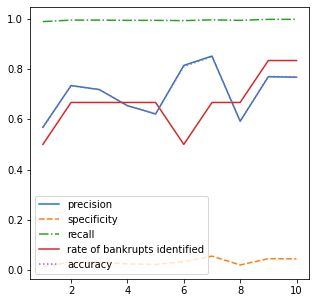

In [28]:
tp_plot = [x / 6 for x in tp_list]
number_of_leafs = list(range(1, 11))
# plot lines
font = {'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.figure(figsize=(5, 5))
plt.plot(number_of_leafs, precision_list, label="precision", linestyle="-")
plt.plot(number_of_leafs, specificity_list, label="specificity", linestyle="--")
plt.plot(number_of_leafs, recall_list, label="recall", linestyle="-.")
plt.plot(number_of_leafs, tp_plot, label="rate of bankrupts identified", linestyle="-")
plt.plot(number_of_leafs, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

In [29]:
sfs = SequentialFeatureSelector(clf, n_features_to_select=7)
sfs.fit(X_train, y_train)
cols = sfs.get_support(indices=True)
important_features = pd.DataFrame(X_train.iloc[:,cols].columns)
important_features

,0
0,"2019, Оборачиваемость кредиторской задолженности, разы"
1,"2019, Коэффициент оборачиваемости совокупных активов, %"
2,"2019, Коэффициент соотношения заемных и собственных средств, %"
3,"2019, Коэффициент концентрации собственного капитала (автономии), %"
4,"2019, Коэффициент обеспеченности собственными оборотными средствами, %"
5,"2019, Рентабельность затрат, %"
6,"2019, Коэффициент текущей ликвидности, %"


In [30]:
clf = LinearSVC(max_iter=10000).fit(X_train[important_features[0]], y_train)
y_pred = clf.predict(X_test[important_features[0]])
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

this is fine      0.995     0.851     0.918       451
    bankrupt      0.056     0.667     0.104         6

    accuracy                          0.849       457
   macro avg      0.526     0.759     0.511       457
weighted avg      0.982     0.849     0.907       457

[[384  67]
 [  2   4]]


Most of parameters are the same as with logistic regression, some of it intersect with decision tree, showing quite a good consistency of results, but due to train_test_split the coefficients might slightly change